# Pipeline for High-z Radio Galaxies 13: Distribution of transformed features

In this notebook, we want to plot distributions (histograms) of transformed features.  
This would depend on the model and on the used dataset/area from which features are retrieved.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

---

In [3]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = True

### Load data

In [4]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

In [5]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Full, Validation, Training, Test, Test+Train, Val+Unknown

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Fint_VLAS82',\
                       'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                       'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                       'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Stotal_TGSS',\
                       'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                       'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [11]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

In [12]:
if used_area == 'HETDEX':
    if HETDEX_subset != 'Full':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                            random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
        train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                            random_state=seed, stratify=train_test_df.loc[:, 'class'])
        print('Shape of used data in HETDEX')
        print('(Confirmed galaxies and AGN)')
        print('-' * 50)
        print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
        print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
        print(f'Training data:                      {train_df.shape}')
        print(f'Testing data:                       {test_df.shape}')
        print(f'Unseen Data For Validation:         {validation_df.shape}')
        print('-' * 50)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                            'Validation': validation_df, 'Val+Unknown': pd.concat([validation_df, unknown_cat_df])}
        full_catalog_df = selected_dataset[HETDEX_subset]

In [13]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [14]:
seed                                = 42

### Load models

In [15]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions

In [16]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=threshold_star, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [18]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [19]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [20]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=6)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [21]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [22]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

In [23]:
feat_cols_names   = {'W1mproPM': 'W1 (CW)', 'W2mproPM': 'W2 (CW)', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3 (AW)', 'W4mag': 'W4 (AW)', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

---

## Transform feature values

Flags to run on sub-set of base learners.

In [24]:
run_AGN_analysis    = True
run_radio_analysis  = True
run_z_analysis      = True
run_high_z_analysis = True

#### Select relevant sources

In this case, high-redshift sources

In [25]:
run_high_z_flag      = True  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.

In [26]:
if run_high_z_flag:
    filter_selection = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit) & np.array(full_catalog_df.loc[:, 'class'] == 1)
elif not run_high_z_flag:
    filter_selection = np.ones_like(full_catalog_df.loc[:, 'Z']).astype(bool)

In [27]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### AGN/galaxy model

In [28]:
if run_AGN_analysis:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

In [29]:
if run_AGN_analysis:
    sample_size_AGN  = 1000
    filter_conf_sour = (full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)
    sub_size_AGN     = np.sum(filter_conf_sour)
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 3,304


In [31]:
if run_AGN_analysis:
    estimators_list_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [34]:
if run_AGN_analysis:
    # reduced_data_AGN      = full_catalog_df.loc[filter_selection,\
    #                                             get_final_column_names(AGN_gal_clf,\
    #                                                                    full_catalog_df)].sample(n=sub_size_AGN,\
    #                                                                                             random_state=seed).copy()
    reduced_data_AGN      = full_catalog_df.loc[:, gf.get_final_column_names(AGN_gal_clf,\
                                                                       full_catalog_df)].copy()
    reduced_idx_AGN       = reduced_data_AGN.index
    reduced_cols_AGN_base = reduced_data_AGN.columns
    reduced_cols_AGN      = reduced_data_AGN.columns.insert(0, estimators_list_AGN[0])
    if len(estimators_list_AGN) > 1:
        for est_name in estimators_list_AGN[1::]:
            reduced_cols_AGN = reduced_cols_AGN.insert(0, est_name)

In [35]:
if run_AGN_analysis:
    # reduced_data_AGN_df = pd.DataFrame(AGN_gal_clf.transform(full_catalog_df.loc[filter_selection]),\
    #                                    columns=reduced_cols_AGN, index=reduced_idx_AGN)
    reduced_data_AGN_df = pd.DataFrame(AGN_gal_clf.transform(full_catalog_df),\
                                       columns=reduced_cols_AGN, index=reduced_idx_AGN)

In [36]:
if run_AGN_analysis:
    known_sources_AGN = (full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)

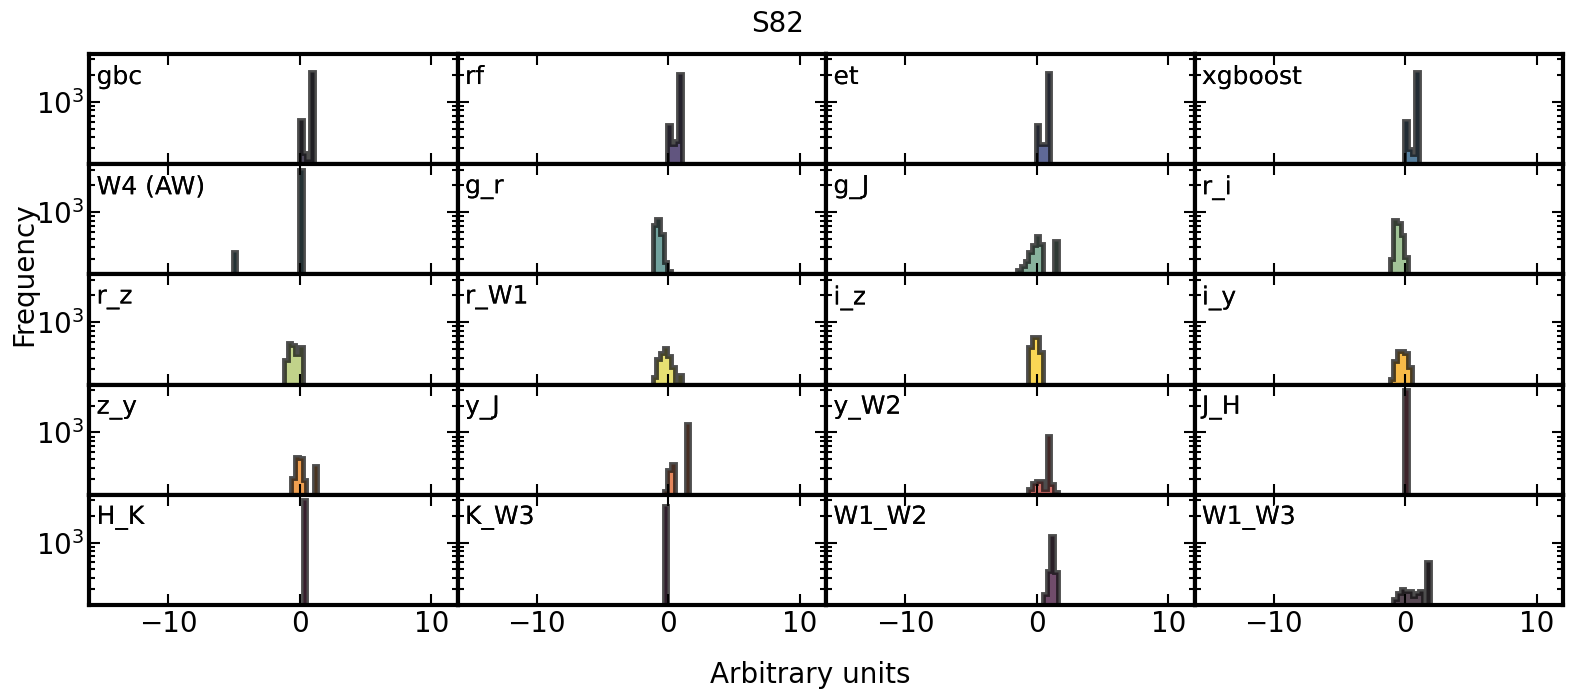

In [37]:
if run_AGN_analysis:
    n_cols = 4
    n_rows = int(np.ceil((len(reduced_cols_AGN)) / 4))

    min_feature     = reduced_data_AGN_df.loc[known_sources_AGN].min().min()
    max_feature     = reduced_data_AGN_df.loc[known_sources_AGN].max().max()
    feat_bins       = np.linspace(min_feature, max_feature, 100)

    fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=False)

    grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                       height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
    axs             = {}
    cmap_name       = 'cmr.pride'  # 'cmr.pride', 'cet_CET_R1'

    for count, feat in enumerate(reduced_cols_AGN):
        if count == 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         xscale='linear', yscale='log')
        elif count != 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         sharex=axs[0], sharey=axs[0])

        # filt_lims = np.array(full_catalog_df.loc[:, feat] != mag_cols_lim[feat])
        axs[count].hist(reduced_data_AGN_df.loc[known_sources_AGN, feat], bins=feat_bins, histtype='stepfilled',
                        ec='k', lw=3.5, fc=plt.get_cmap(cmap_name, len(reduced_cols_AGN))(count),
                        alpha=0.75, label=f'{feat}', density=False)

        axs[count].tick_params(which='both', top=True, right=True, direction='in')
        axs[count].tick_params(axis='both', which='major', labelsize=20)
        axs[count].tick_params(which='major', length=8, width=1.5)
        axs[count].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        #axs[count].grid(zorder=0)
        if count % n_cols != 0:
            plt.setp(axs[count].get_yticklabels(), visible=False)
        # if np.ceil((count + 1) / n_cols) != n_rows:
        #     plt.setp(axs[count].get_xticklabels(), visible=False)
        if count < (len(reduced_cols_AGN) - n_cols):
            plt.setp(axs[count].get_xticklabels(), visible=False)
        try:
            feat_name_str = feat_cols_names[feat]
        except:
            feat_name_str = feat
        axs[count].annotate(text=f'{feat_name_str}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
        #axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
        #                     xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
        axs[0].set_xlim(left=np.floor(min_feature), right=np.ceil(max_feature))
        # axs[0].set_xlim(left=np.floor(min_feature), right=15)
        # axs[0].invert_xaxis()
        # axs[count].legend(loc=2)
    
    if used_area != 'HETDEX':
        sup_title = used_area
        area_save = used_area
    elif used_area == 'HETDEX':
        sup_title = f'{used_area} - {HETDEX_subset}'
        area_save = f'{used_area}_{HETDEX_subset}'
    fig.suptitle(sup_title, fontsize=20)
    fig.supxlabel('Arbitrary units', fontsize=20, x=0.52)
    fig.supylabel('Frequency', fontsize=20, va='bottom')

    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hists_transf_feats_AGN_gal_pipe_{area_save}.pdf', bbox_inches='tight')
    plt.show()

---

#### Radio detection model

In [38]:
if run_radio_analysis:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

In [39]:
if run_radio_analysis:
    sample_size_radio   = 1000
    filter_pred_AGN     = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    sample_size_radio   = len(full_catalog_df)
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 369,093


In [42]:
if run_radio_analysis:
    estimators_list_radio   = gf.get_base_estimators_names(radio_det_clf)

In [43]:
if run_radio_analysis:
    reduced_data_radio      = full_catalog_df.loc[filter_pred_AGN, gf.get_final_column_names(radio_det_clf, full_catalog_df)]
    reduced_idx_radio       = reduced_data_radio.index
    reduced_cols_radio_base = reduced_data_radio.columns
    reduced_cols_radio      = reduced_data_radio.columns.insert(0, estimators_list_radio[0])
    if len(estimators_list_radio) > 1:
        for est_name in estimators_list_radio[1::]:
            reduced_cols_radio = reduced_cols_radio.insert(0, est_name)

In [44]:
if run_radio_analysis:
    # reduced_data_radio_df = pd.DataFrame(radio_det_clf.transform(reduced_data_radio),\
    #                                    columns=reduced_cols_radio, index=reduced_idx_radio)
    reduced_data_radio_df = pd.DataFrame(radio_det_clf.transform(reduced_data_radio),\
                                       columns=reduced_cols_radio, index=reduced_idx_radio)

In [45]:
if run_radio_analysis:
    known_sources_radio = full_catalog_df.loc[:, 'class'] == 1

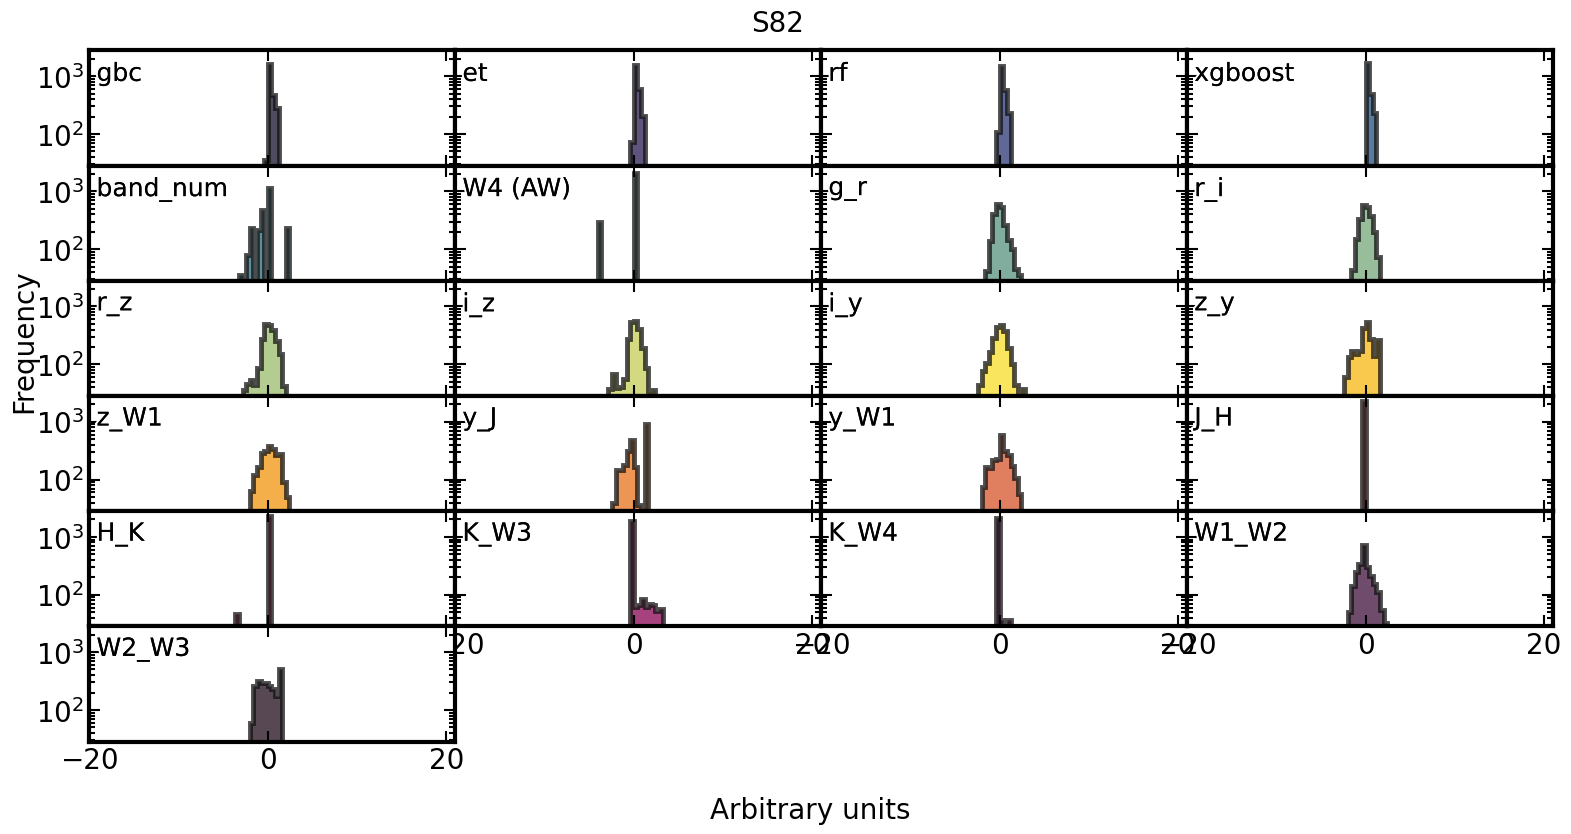

In [46]:
if run_radio_analysis:
    n_cols = 4
    n_rows = int(np.ceil((len(reduced_cols_radio)) / 4))

    min_feature     = reduced_data_radio_df.loc[known_sources_radio].min().min()
    max_feature     = reduced_data_radio_df.loc[known_sources_radio].max().max()
    feat_bins       = np.linspace(min_feature, max_feature, 100)

    fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=False)

    grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                       height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
    axs             = {}
    cmap_name       = 'cmr.pride'  # 'cmr.pride', 'cet_CET_R1'

    for count, feat in enumerate(reduced_cols_radio):
        if count == 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         xscale='linear', yscale='log')
        elif count != 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         sharex=axs[0], sharey=axs[0])

        # filt_lims = np.array(full_catalog_df.loc[:, feat] != mag_cols_lim[feat])
        axs[count].hist(reduced_data_radio_df.loc[known_sources_radio, feat], bins=feat_bins, histtype='stepfilled',
                        ec='k', lw=3.5, fc=plt.get_cmap(cmap_name, len(reduced_cols_radio))(count),
                        alpha=0.75, label=f'{feat}', density=False)

        axs[count].tick_params(which='both', top=True, right=True, direction='in')
        axs[count].tick_params(axis='both', which='major', labelsize=20)
        axs[count].tick_params(which='major', length=8, width=1.5)
        axs[count].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        #axs[count].grid(zorder=0)
        if count % n_cols != 0:
            plt.setp(axs[count].get_yticklabels(), visible=False)
        # if np.ceil((count + 1) / n_cols) != n_rows:
        #     plt.setp(axs[count].get_xticklabels(), visible=False)
        if count < (len(reduced_cols_radio) - n_cols):
            plt.setp(axs[count].get_xticklabels(), visible=False)
        try:
            feat_name_str = feat_cols_names[feat]
        except:
            feat_name_str = feat
        axs[count].annotate(text=f'{feat_name_str}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
        #axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
        #                     xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
        axs[0].set_xlim(left=np.floor(min_feature), right=np.ceil(max_feature))
        # axs[0].set_xlim(left=np.floor(min_feature), right=15)
        # axs[0].invert_xaxis()
        # axs[count].legend(loc=2)
    
    if used_area != 'HETDEX':
        sup_title = used_area
        area_save = used_area
    elif used_area == 'HETDEX':
        sup_title = f'{used_area} - {HETDEX_subset}'
        area_save = f'{used_area}_{HETDEX_subset}'
    fig.suptitle(sup_title, fontsize=20)
    fig.supxlabel('Arbitrary units', fontsize=20, x=0.52)
    fig.supylabel('Frequency', fontsize=20, va='bottom')

    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hists_transf_feats_radio_pipe_{area_save}.pdf', bbox_inches='tight')
    plt.show()

---

#### First redshift prediction model

In [47]:
if run_z_analysis:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

In [48]:
if run_z_analysis:
    sample_size_z        = 1000
    filter_pred_rAGN     = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z        = np.sum(filter_pred_rAGN)
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 6,411


In [50]:
if run_z_analysis:
    estimators_list_z = gf.get_base_estimators_names(redshift_reg)

In [51]:
if run_z_analysis:
    reduced_data_z      = full_catalog_df.loc[filter_pred_rAGN, gf.get_final_column_names(redshift_reg, full_catalog_df)]
    reduced_idx_z       = reduced_data_z.index
    reduced_cols_z      = reduced_data_z.columns
    reduced_cols_z_base = reduced_data_z.columns
    reduced_cols_z      = reduced_data_z.columns.insert(0, estimators_list_z[0])
    if len(estimators_list_z) > 1:
        for est_name in estimators_list_z[1::]:
            reduced_cols_z = reduced_cols_z.insert(0, est_name)

In [52]:
if run_z_analysis:
    # reduced_data_z_df = pd.DataFrame(redshift_reg.transform(reduced_data_z),\
    #                                    columns=reduced_cols_z, index=reduced_idx_z)
    reduced_data_z_df = pd.DataFrame(redshift_reg.transform(reduced_data_z),\
                                       columns=reduced_cols_z, index=reduced_idx_z)

In [53]:
if run_z_analysis:
    known_sources_z = full_catalog_df.loc[:, 'pred_radio_AGN'] == 1

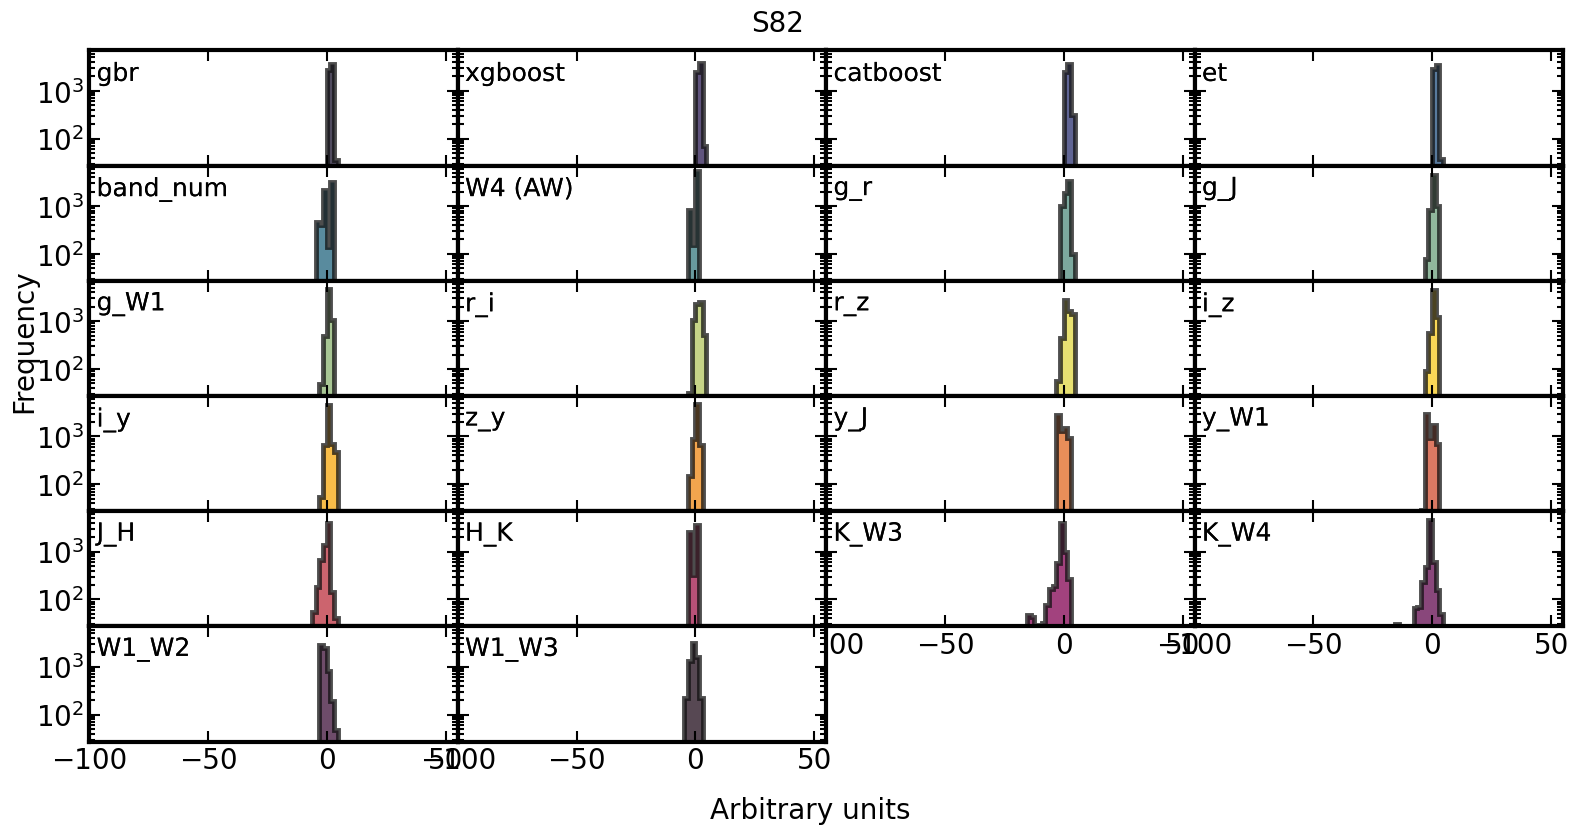

In [54]:
if run_z_analysis:
    n_cols = 4
    n_rows = int(np.ceil((len(reduced_cols_z)) / 4))

    min_feature     = reduced_data_z_df.loc[known_sources_z].min().min()
    max_feature     = reduced_data_z_df.loc[known_sources_z].max().max()
    feat_bins       = np.linspace(min_feature, max_feature, 100)

    fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=False)

    grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                       height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
    axs             = {}
    cmap_name       = 'cmr.pride'  # 'cmr.pride', 'cet_CET_R1'

    for count, feat in enumerate(reduced_cols_z):
        if count == 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         xscale='linear', yscale='log')
        elif count != 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         sharex=axs[0], sharey=axs[0])

        # filt_lims = np.array(full_catalog_df.loc[:, feat] != mag_cols_lim[feat])
        axs[count].hist(reduced_data_z_df.loc[known_sources_z, feat], bins=feat_bins, histtype='stepfilled',
                        ec='k', lw=3.5, fc=plt.get_cmap(cmap_name, len(reduced_cols_z))(count),
                        alpha=0.75, label=f'{feat}', density=False)

        axs[count].tick_params(which='both', top=True, right=True, direction='in')
        axs[count].tick_params(axis='both', which='major', labelsize=20)
        axs[count].tick_params(which='major', length=8, width=1.5)
        axs[count].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        #axs[count].grid(zorder=0)
        if count % n_cols != 0:
            plt.setp(axs[count].get_yticklabels(), visible=False)
        # if np.ceil((count + 1) / n_cols) != n_rows:
        #     plt.setp(axs[count].get_xticklabels(), visible=False)
        if count < (len(reduced_cols_z) - n_cols):
            plt.setp(axs[count].get_xticklabels(), visible=False)
        try:
            feat_name_str = feat_cols_names[feat]
        except:
            feat_name_str = feat
        axs[count].annotate(text=f'{feat_name_str}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
        #axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
        #                     xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
        axs[0].set_xlim(left=np.floor(min_feature), right=np.ceil(max_feature))
        # axs[0].set_xlim(left=np.floor(min_feature), right=15)
        # axs[0].invert_xaxis()
        # axs[count].legend(loc=2)
    
    if used_area != 'HETDEX':
        sup_title = used_area
        area_save = used_area
    elif used_area == 'HETDEX':
        sup_title = f'{used_area} - {HETDEX_subset}'
        area_save = f'{used_area}_{HETDEX_subset}'
    fig.suptitle(sup_title, fontsize=20)
    fig.supxlabel('Arbitrary units', fontsize=20, x=0.52)
    fig.supylabel('Frequency', fontsize=20, va='bottom')

    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hists_transf_feats_z_pipe_{area_save}.pdf', bbox_inches='tight')
    plt.show()

---

#### Second redshift prediction model

In [65]:
if run_high_z_analysis & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

In [66]:
if run_high_z_analysis & use_second_z_model:
    sample_size_high_z          = 1000
    filter_pred_rAGN_high_z     = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    sample_size_high_z          = np.sum(filter_pred_rAGN_high_z)
    print(f'Number of selected elements: {sample_size_high_z:,}')

Number of selected elements: 3,117


In [67]:
if run_high_z_analysis & use_second_z_model:
    estimators_list_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [68]:
if run_high_z_analysis & use_second_z_model:
    reduced_data_high_z      = full_catalog_df.loc[filter_pred_rAGN_high_z, gf.get_final_column_names(redshift_reg_2, full_catalog_df)]
    reduced_idx_high_z       = reduced_data_high_z.index
    reduced_cols_high_z_base = reduced_data_high_z.columns
    reduced_cols_high_z      = reduced_data_high_z.columns.insert(0, estimators_list_high_z[0])
    if len(estimators_list_high_z) > 1:
        for est_name in estimators_list_high_z[1::]:
            reduced_cols_high_z = reduced_cols_high_z.insert(0, est_name)

In [69]:
if run_high_z_analysis & use_second_z_model:
    # reduced_data_high_z_df = pd.DataFrame(redshift_reg.transform(reduced_data_high_z),\
    #                                    columns=reduced_cols_high_z, index=reduced_idx_high_z)
    reduced_data_high_z_df = pd.DataFrame(redshift_reg_2.transform(reduced_data_high_z),\
                                       columns=reduced_cols_high_z, index=reduced_idx_high_z)

In [77]:
if run_high_z_analysis & use_second_z_model:
    known_sources_high_z = np.array(full_catalog_df.loc[reduced_idx_high_z, 'pred_radio_AGN'] == 1) &\
                            np.array(full_catalog_df.loc[reduced_idx_high_z, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))

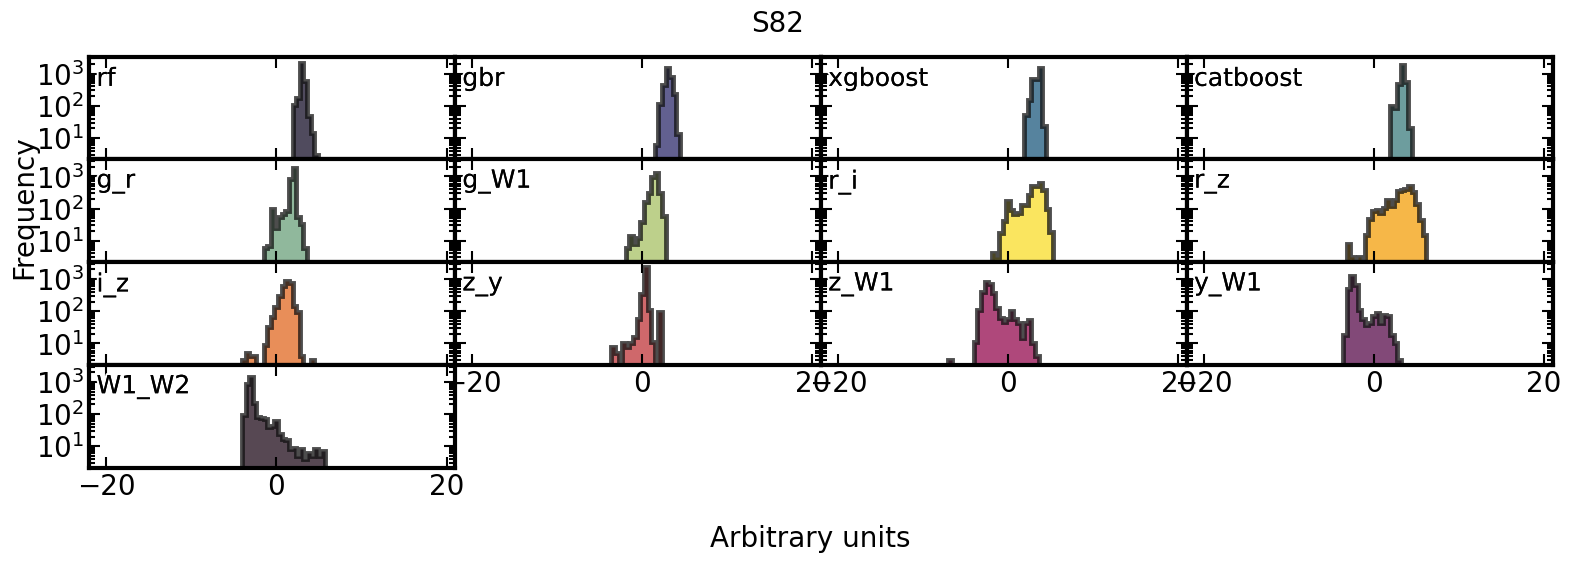

In [82]:
if run_high_z_analysis & use_second_z_model:
    n_cols = 4
    n_rows = int(np.ceil((len(reduced_cols_high_z)) / 4))

    min_feature     = reduced_data_high_z_df.loc[known_sources_high_z].min().min()
    max_feature     = reduced_data_high_z_df.loc[known_sources_high_z].max().max()
    feat_bins       = np.linspace(min_feature, max_feature, 100)

    fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=False)

    grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                       height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
    axs             = {}
    cmap_name       = 'cmr.pride'  # 'cmr.pride', 'cet_CET_R1'

    for count, feat in enumerate(reduced_cols_high_z):
        if count == 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         xscale='linear', yscale='log')
        elif count != 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         sharex=axs[0], sharey=axs[0])

        # filt_lims = np.array(full_catalog_df.loc[:, feat] != mag_cols_lim[feat])
        axs[count].hist(reduced_data_high_z_df.loc[known_sources_high_z, feat], bins=feat_bins, histtype='stepfilled',
                        ec='k', lw=3.5, fc=plt.get_cmap(cmap_name, len(reduced_cols_high_z))(count),
                        alpha=0.75, label=f'{feat}', density=False)

        axs[count].tick_params(which='both', top=True, right=True, direction='in')
        axs[count].tick_params(axis='both', which='major', labelsize=20)
        axs[count].tick_params(which='major', length=8, width=1.5)
        axs[count].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        #axs[count].grid(zorder=0)
        if count % n_cols != 0:
            plt.setp(axs[count].get_yticklabels(), visible=False)
        # if np.ceil((count + 1) / n_cols) != n_rows:
        #     plt.setp(axs[count].get_xticklabels(), visible=False)
        if count < (len(reduced_cols_high_z) - n_cols):
            plt.setp(axs[count].get_xticklabels(), visible=False)
        try:
            feat_name_str = feat_cols_names[feat]
        except:
            feat_name_str = feat
        axs[count].annotate(text=f'{feat_name_str}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=gf.pe2)
        #axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
        #                     xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=gf.pe2)
        axs[0].set_xlim(left=np.floor(min_feature), right=np.ceil(max_feature))
        # axs[0].set_xlim(left=np.floor(min_feature), right=15)
        # axs[0].invert_xaxis()
        # axs[count].legend(loc=2)
    
    if used_area != 'HETDEX':
        sup_title = used_area
        area_save = used_area
    elif used_area == 'HETDEX':
        sup_title = f'{used_area} - {HETDEX_subset}'
        area_save = f'{used_area}_{HETDEX_subset}'
    fig.suptitle(sup_title, fontsize=20)
    fig.supxlabel('Arbitrary units', fontsize=20, x=0.52)
    fig.supylabel('Frequency', fontsize=20, va='bottom')

    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hists_transf_feats_high_z_pipe_{area_save}.pdf', bbox_inches='tight')
    plt.show()